# Tweet Analysis for ETE 2017

## Status

As of this writing,
this analysis is a work in progress.
It may change as I begin to understand the tweet data better.

## Overview

Every year [Chariot Solutions](http://chariotsolutions.com/)
puts on their [Philly Emerging Technology for the Enterprise](http://2017.phillyemergingtech.com/) or ETE confernece.
It's a great regional software confenrece.
And it just happens that they make en effort to encourage 
the use of social media during the confernce.
This year's confernece was April 18-19.

A while back, I did some analysis of the [WXPN A-Z Playlist](https://github.com/asudell/a2z).
It was a small enough data set to be tractable as a side project,
but interesting enough to require a bit of investigation and to learn a few things.
At the time I also built a quick [Twitter Capture program](https://github.com/asudell/twitter-capture) with the intent of doing some tweet stream analysis.
But doing the playlist analysis basically on the fly
took enough time that I never got around the the tweet analysis.

So, this is an attempt to do some tweet stream analyis
looking at the [#PhillyETE](https://twitter.com/search?q=%23PhillyETE) hashtag
for the period around the confenrce.

## Loading The Data

The data capture its self was done offline,
using [Twitter Capture](https://github.com/asudell/twitter-capture)
and the resulting directory of json tweets copied locally.

For starters, we'll just walk the files and build up a DataFrame 
with a few attributes.
Along the way we'll flatten the structure a bit.
Somethings, like entities are collections and don't flatten well at all.
In those cases, we can build up independent DataFrames ane join on them later.

In [14]:
%matplotlib inline
from IPython.display import display, HTML

from fnmatch import fnmatch
from os import listdir, path
import json
import pandas as pd
import numpy as np
from datetime import datetime
import pytz

utc = pytz.utc
eastern = pytz.timezone('America/New_York')


tweets = pd.DataFrame(None, columns = ('created_at',
                                      'favorite_count',
                                      'id_str',
                                      'retweet_count',
                                      'text',
                                      'user_id_str',
                                      'user_name',
                                      'user_screen_name',
                                      ))

mentions = pd.DataFrame(None, columns = ('id_str',
                                        'user_id_str',
                                        'user_name',
                                        'user_screen_name',
                                        ))

media = pd.DataFrame(None, columns = ('id_str',
                                     'media_type',
                                     'media_url',
                                     ))

tweet_dir = './tweets'
for file in listdir(tweet_dir):
    if fnmatch(file, '*.json'):
        with open(path.join(tweet_dir, file)) as tweet_file:
            tweet = json.load(tweet_file)
            tweets = tweets.append({'created_at': utc.localize(datetime.strptime(tweet['created_at'],
                                                '%a %b %d %H:%M:%S +0000 %Y')).astimezone(eastern).replace(tzinfo=None),
                                   'favorite_count': tweet['favorite_count'],
                                   'id_str': tweet['id_str'],
                                   'retweet_count': tweet['retweet_count'],
                                   'text': tweet['text'],
                                   'user_id_str': tweet['user']['id_str'],
                                   'user_name': tweet['user']['name'],
                                   'user_screen_name': tweet['user']['screen_name']},
                                  ignore_index = True)
            
            for mention in tweet['entities']['user_mentions']:
                mentions = mentions.append({'id_str': tweet['id_str'],
                                    'user_id_str': mention['id_str'],
                                    'user_name': mention['name'],
                                    'user_screen_name': mention['screen_name']},
                                   ignore_index = True)
                
            if 'media' in tweet['entities']:
                for medium in tweet['entities']['media']:
                    media = media.append({'id_str': tweet['id_str'],
                                     'media_type': medium['type'],
                                     'media_url': medium['media_url']},
                                    ignore_index = True)
            


## Tweet Rates

Overall we have 1713 tweets that run from April 10 to April 22.
Most of those we'd expect to be during the conference.
But we can prove that by doing a quick timeseries plot,
counting tweets in 3 hour buckets over that period.

Sure enough, the tweet rate is basically flatlined with a few small blips
other than the two days of the conference and a smaller burst the next day.

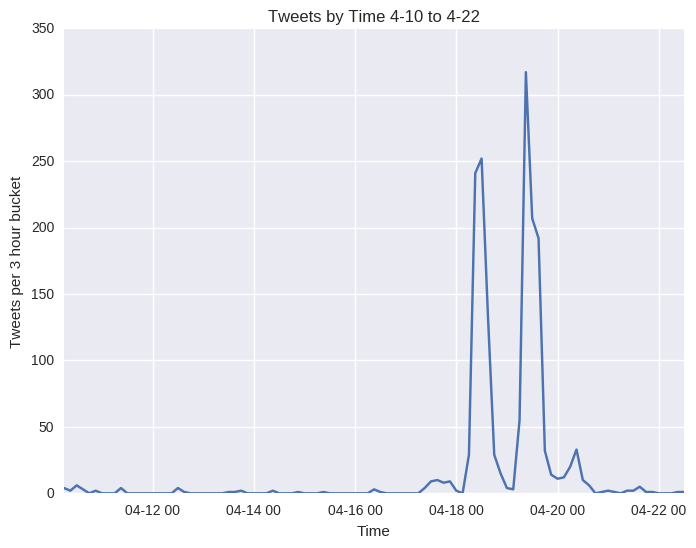

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

time_buckets = tweets.set_index('created_at').groupby(pd.TimeGrouper('3H')).count()['id_str']
tweets_by_time = pd.DataFrame(zip(mdates.date2num(time_buckets.keys().tolist()), time_buckets.tolist()),
                             columns=('Time', 'Tweets'))
tweets_by_time['unit'] = 'unit'
f, ax = plt.subplots(figsize = (8, 6))
sns.set_color_codes('pastel')
sns.tsplot(tweets_by_time, time='Time', value='Tweets', unit='unit', err_style=None)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H'))
ax.set_title("Tweets by Time 4-10 to 4-22")
ax.set(ylabel='Tweets per 3 hour bucket')

We can zoom in on the two individual days
and look a bit closer.

One Tuesday, there are a few spikes.
The largest is at 12 noon.
But there are others at 11:10, 4:00 and 9:00.
The last is during the Blair MacIntyre's keynote.
It's not obvious what drive the other spikes.
Perhaps that will come out by looking at the content.

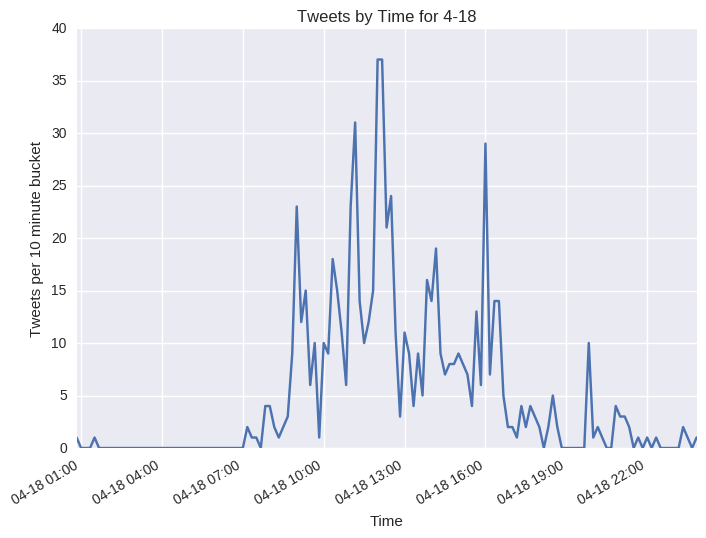

In [16]:

t = tweets[(tweets['created_at'] > np.datetime64('2017-04-18')) & (tweets['created_at'] < np.datetime64('2017-04-19'))]
time_buckets = t.set_index('created_at').groupby(pd.TimeGrouper('10min')).count()['id_str']
tweets_by_time = pd.DataFrame(zip(mdates.date2num(time_buckets.keys().tolist()), time_buckets.tolist()),
                             columns=('Time', 'Tweets'))
tweets_by_time['unit'] = 'unit'
f, ax = plt.subplots(figsize = (8, 6))
sns.set_color_codes('pastel')
sns.tsplot(tweets_by_time, time='Time', value='Tweets', unit='unit', err_style=None)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
f.autofmt_xdate()
ax.set_title("Tweets by Time for 4-18")
ax.set(ylabel='Tweets per 10 minute bucket')

By contrast, Wednsday is both more evenly distributed
and has a higher level of tweeting in general.
Also there is a big spike at 9:00.
That's during Scott Hanselman's keynote
which was absolutly halarious.

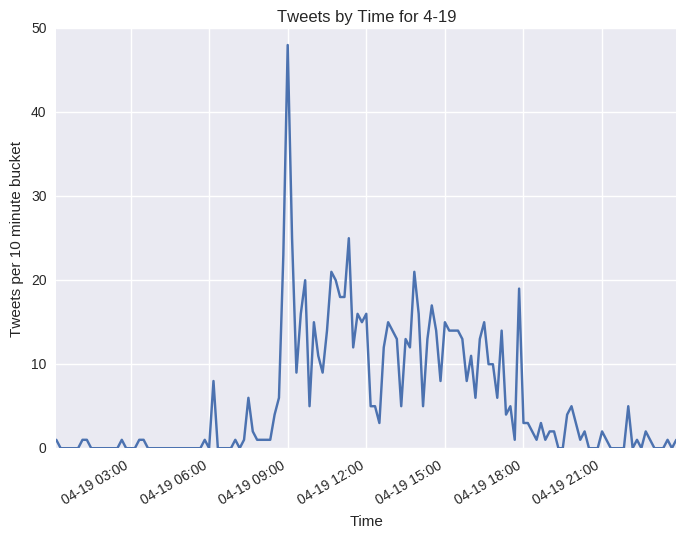

In [17]:
t = tweets[(tweets['created_at'] > np.datetime64('2017-04-19')) & (tweets['created_at'] < np.datetime64('2017-04-20'))]
time_buckets = t.set_index('created_at').groupby(pd.TimeGrouper('10min')).count()['id_str']
tweets_by_time = pd.DataFrame(zip(mdates.date2num(time_buckets.keys().tolist()), time_buckets.tolist()),
                             columns=('Time', 'Tweets'))
tweets_by_time['unit'] = 'unit'
f, ax = plt.subplots(figsize = (8, 6))
sns.set_color_codes('pastel')
sns.tsplot(tweets_by_time, time='Time', value='Tweets', unit='unit', err_style=None)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
f.autofmt_xdate()
ax.set_title("Tweets by Time for 4-19")
ax.set(ylabel='Tweets per 10 minute bucket')

## Looking At Users

For starters we can group the tweets by user and discover who was partipating the most in the stream.
It's not surprizing to see Chariot Solutions [@ChariotSolution](https://twitter.com/ChariotSolution) at the top.
They are hosting the confernece.
Likewise, Tracey Welson Rossman [@TWelsonRossman](https://twitter.com/TWelsonRossman)
is thier Chief Marketing Officer.
But there are number of users 
such as Michael P. Redlich [@mpredi](https://twitter.com/mpredli),
Martain Snyder [@MartainSnyder](https://twitter.com/MartinSnyder),
Maurice Gaston [@mofro](https://twitter.com/mofro),
and Archimage [@Archimage)[https://twitter.com/Archimage)
who are seriously engaged.

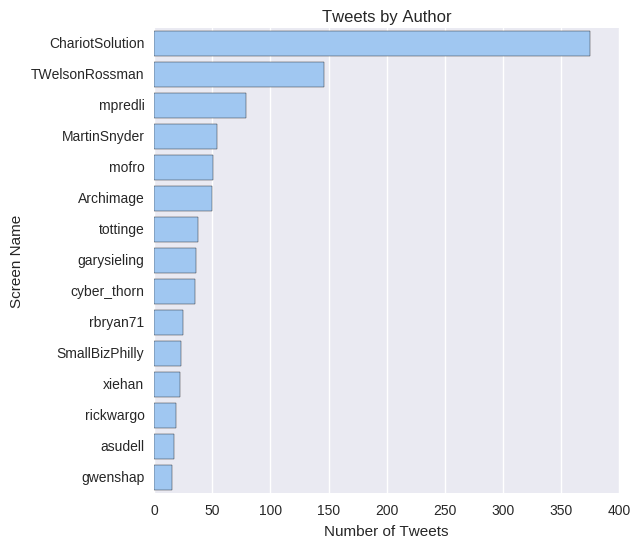

In [18]:
authors = tweets.groupby(['user_screen_name'])['id_str'].count()
author_freq = pd.DataFrame(zip(authors.keys().tolist(), authors.tolist()),
                          columns = ('screen_name', 'tweets'))

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(y='screen_name', x='tweets',
            data = author_freq.sort_values(['tweets'], ascending = False).head(15),
           orient='h', color='b')
ax.set(xlabel = "Number of Tweets", ylabel = 'Screen Name')
ax.set_title("Tweets by Author")

By contrast, if we look at mentions, we can get some 
indication perhaps of which speakers were popular.

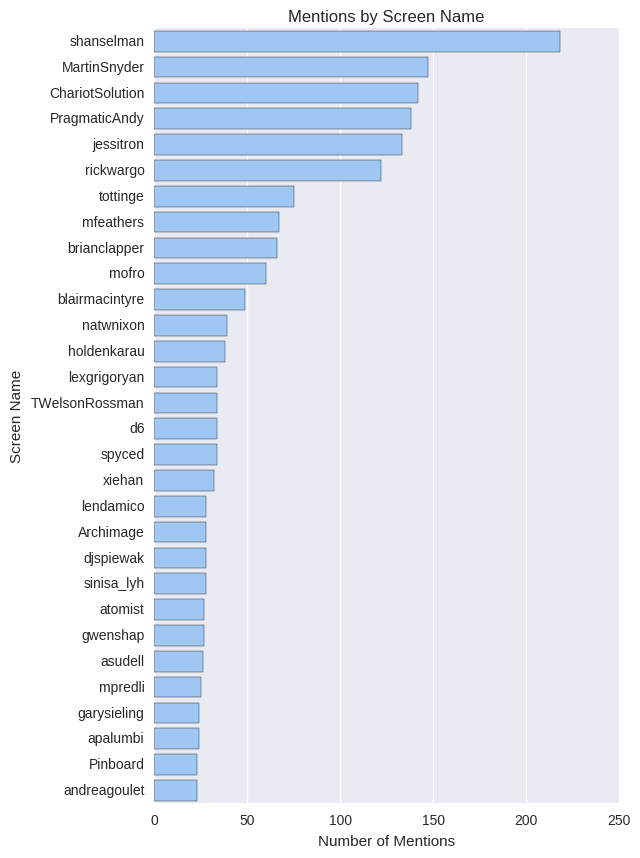

In [21]:
mention_counts = mentions.groupby(['user_screen_name'])['id_str'].count()
mention_freq = pd.DataFrame(zip(mention_counts.keys().tolist(),
                               mention_counts.tolist()),
                           columns = ('screen_name', 'mentions'))

f, ax = plt.subplots(figsize=(6, 10))
sns.barplot(y='screen_name', x='mentions',
            data = mention_freq.sort_values(['mentions'], ascending = False).head(30),
           orient='h', color='b')
ax.set(xlabel = "Number of Mentions", ylabel = 'Screen Name')
ax.set_title("Mentions by Screen Name")

That's interesting.
Scott Hanselman [@shanselman](https://twitter.com/shanselman) is way out front.
Not surprizing. 
He gave a great talk and the tweet strem was most active during his talk.
But Martin Snyder has just under 150 mentionsand he didn't give a talk,
though he was one of the most active live tweeters.
Perhaps we are seeing retweets and quotes driving that.